ELEC6910X Advanced Topics in AI and Healthcare

# Assignment 1 - Problem 3: Surgical Phase Recognition

***Holy Lovenia - 20814158***

------

In [1]:
from collections import OrderedDict
from PIL import Image
from pytorch_metric_learning import losses
from torch import nn
from torch.autograd import Variable
from torch.nn import init
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision.transforms import (
    CenterCrop,
    ColorJitter,
    Compose,
    Normalize,
    RandomHorizontalFlip,
    RandomVerticalFlip,
    RandomResizedCrop,
    RandomRotation,
    Resize,
    ToTensor,
)
from transformers import AutoConfig, AutoFeatureExtractor, AutoModelForImageClassification, TrainingArguments, Trainer, EarlyStoppingCallback
from tqdm import tqdm

import datasets
import h5py
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
import surface_distance.metrics as sf
import torch
import torch.nn.functional as F
import torch.optim as optim
import torchio as tio
import torchmetrics
import torchvision

In [2]:
RANDOM_SEED = 42

def set_all_seeds(seed):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.backends.cudnn.deterministic = True

set_all_seeds(RANDOM_SEED)

## Problem 3: Surgical Phase Recognition

In [3]:
NUM_CLASSES = 7

In [4]:
model_name_or_path = "microsoft/resnet-50"

### Data loading

#### Function declaration

Loading function for `problem3_datas` dataset.

In [5]:
def problem3_load_dataset(
    manifest_dir_path,
    vid_dir_path,
    only_these_ids=[],
    num_prev_frames=0,
    img_column_name="Frame",
    label_column_name="Phase",
    return_df=False):
    
    all_manifest_dfs = []
    
    for manifest_file_name in os.listdir(manifest_dir_path):
        data_id = int(manifest_file_name.split("_")[-1].replace(".csv", ""))
        if data_id in only_these_ids:
            manifest_path = os.path.join(manifest_dir_path, manifest_file_name)
            manifest_df = pd.read_csv(manifest_path)
            manifest_df["video_id"] = data_id
            manifest_df[img_column_name] = f"{os.path.join(vid_dir_path, str(data_id))}/" + manifest_df[img_column_name].astype(str)
            manifest_df = manifest_df.rename(columns={img_column_name: "image", label_column_name: "label"})

            if num_prev_frames != 0:
                prev_frames = {}
                prev_labels = {}
                total_num_frames = len(manifest_df)
                for current_frame_id in range(total_num_frames):
                    for n_before_current in range(num_prev_frames):
                        if prev_frames.get(n_before_current) is None:
                            prev_frames[n_before_current] = []
                            prev_labels[n_before_current] = []
                    
                        if current_frame_id - n_before_current >= 0:
                            prev_frames[n_before_current].append(
                                manifest_df["image"][current_frame_id - n_before_current])
                            prev_labels[n_before_current].append(
                                manifest_df["label"][current_frame_id - n_before_current])
                        else:
                            prev_frames[n_before_current].append(None)
                            prev_labels[n_before_current].append(None)
                            
                for n_before_current in range(num_prev_frames):
                    manifest_df[f"prev_frame_{n_before_current}"] = prev_frames[n_before_current]
                    manifest_df[f"prev_label_{n_before_current}"] = prev_labels[n_before_current]
            
            all_manifest_dfs.append(manifest_df)
    whole_manifest_df = pd.concat(all_manifest_dfs, ignore_index=True)
        
    dataset = datasets.Dataset.from_pandas(whole_manifest_df)
    dataset = dataset.cast_column("image", datasets.Image(decode=True))
    if num_prev_frames != 0:
        for n_before_current in range(num_prev_frames):
            dataset = dataset.cast_column(f"prev_frame_{n_before_current}", datasets.Image(decode=True))
            dataset = dataset.cast_column(f"prev_label_{n_before_current}", datasets.Value("int32"))
    dataset.reset_format()
#     print("after image", len(dataset))
#     dataset = dataset.class_encode_column("label")
#     print("after casting", len(dataset))
#     dataset.features["label"].names = [
#         "Preparation",
#         "Calot Triangle Dissection",
#         "Clipping Cutting",
#         "Gallbladder Dissection",
#         "Gallbladder Packaging",
#         "Cleaning Coagulation",
#         "Gallbladder Retraction"]
    if return_df:
        return dataset, whole_manifest_df
    else:
        return dataset

#### Function utilization

In [6]:
NUM_PREV_FRAMES = 5

Load the `problem3_datas` dataset.

In [7]:
raw_datasets = datasets.DatasetDict()
raw_datasets["train"], train_df = problem3_load_dataset(
    "./data/problem3_datas/annotation/",
    "./data/problem3_datas/",
    num_prev_frames=NUM_PREV_FRAMES,
    only_these_ids=range(1, 6),
    return_df=True)
raw_datasets["valid"] = problem3_load_dataset(
    "./data/problem3_datas/annotation/",
    "./data/problem3_datas/",
    num_prev_frames=NUM_PREV_FRAMES,
    only_these_ids=[41],
    return_df=False)
raw_datasets

Casting the dataset:   0%|          | 0/1 [00:00<?, ?ba/s]

Casting the dataset:   0%|          | 0/1 [00:00<?, ?ba/s]

Casting the dataset:   0%|          | 0/1 [00:00<?, ?ba/s]

Casting the dataset:   0%|          | 0/1 [00:00<?, ?ba/s]

Casting the dataset:   0%|          | 0/1 [00:00<?, ?ba/s]

Casting the dataset:   0%|          | 0/1 [00:00<?, ?ba/s]

Casting the dataset:   0%|          | 0/1 [00:00<?, ?ba/s]

Casting the dataset:   0%|          | 0/1 [00:00<?, ?ba/s]

Casting the dataset:   0%|          | 0/1 [00:00<?, ?ba/s]

Casting the dataset:   0%|          | 0/1 [00:00<?, ?ba/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'label', 'video_id', 'prev_frame_0', 'prev_label_0', 'prev_frame_1', 'prev_label_1', 'prev_frame_2', 'prev_label_2', 'prev_frame_3', 'prev_label_3', 'prev_frame_4', 'prev_label_4'],
        num_rows: 3570
    })
    valid: Dataset({
        features: ['image', 'label', 'video_id', 'prev_frame_0', 'prev_label_0', 'prev_frame_1', 'prev_label_1', 'prev_frame_2', 'prev_label_2', 'prev_frame_3', 'prev_label_3', 'prev_frame_4', 'prev_label_4'],
        num_rows: 776
    })
})

Display the label statistics of the `problem3_datas` dataset.

In [8]:
label_stats = train_df["label"].value_counts()
label_stats

1    1849
3     644
2     255
5     255
6     243
0     225
4      99
Name: label, dtype: int64

Wow, so imbalanced. Let's get the class weights. They can be used to adjust the cross-entropy loss later.

In [9]:
num_train_labels = sum(label_stats)
train_class_weights = []
for i in range(NUM_CLASSES):
    train_class_weights.append(float(round(train_df["label"].value_counts()[i] / num_train_labels, 2)))
train_class_weights

[0.06, 0.52, 0.07, 0.18, 0.03, 0.07, 0.07]

What do the data look like? Let's display a data sample of each class in the `problem2_datas`.

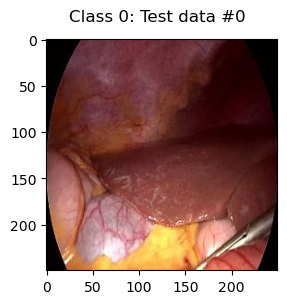

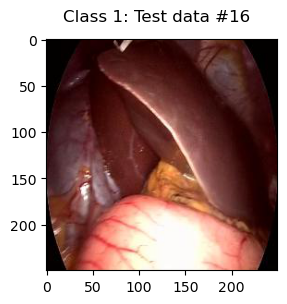

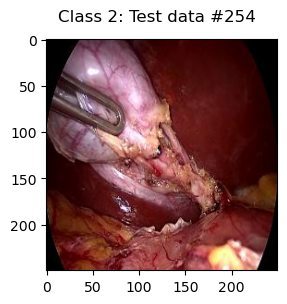

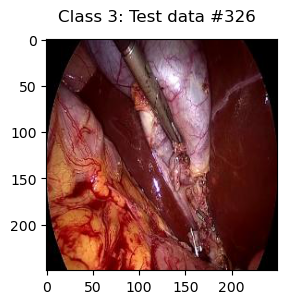

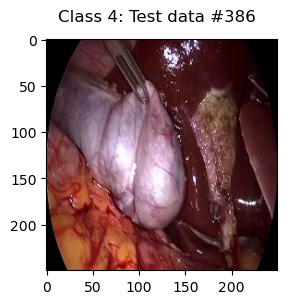

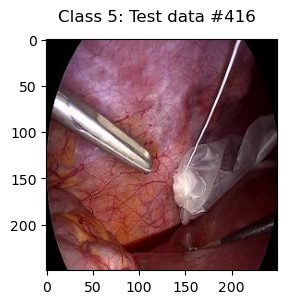

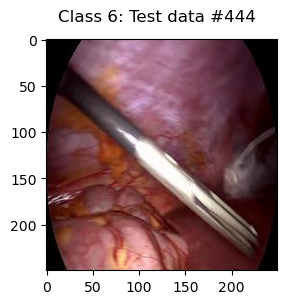

In [10]:
for class_id in range(NUM_CLASSES):
    # Get the index of the first sample from `class_id`
    index = train_df.index[train_df["label"] == class_id][0]
    plt.figure(figsize=(4, 3))
    plt.suptitle(f'Class {class_id}: Test data #{index}', fontsize=12)
    plt.imshow(raw_datasets["train"][int(index)]["image"])

### Preprocessing

Initialize the feature extractor I want to use.

In [11]:
feature_extractor = AutoFeatureExtractor.from_pretrained(model_name_or_path)

#### Function declarations

Augmentation and preprocessing functions.

In [12]:
normalize = Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)
train_transforms = Compose(
        [
            Resize(feature_extractor.size),
            CenterCrop(feature_extractor.size),
            ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.05),
            RandomHorizontalFlip(),
            RandomVerticalFlip(),
            RandomRotation(5),            
            ToTensor(),
            normalize,
        ]
    )

eval_transforms = Compose(
        [
            Resize(feature_extractor.size),
            CenterCrop(feature_extractor.size),
            ToTensor(),
            normalize,
        ]
    )

# import pyarrow as pa
def preprocess_train(example_batch):
    """Apply train_transforms across a batch."""
    example_batch["pixel_values"] = [
        train_transforms(image.convert("RGB")) for image in example_batch["image"]
    ]
    for i in range(NUM_PREV_FRAMES):
        example_batch[f"pixel_values_prev_frame_{i}"] = []
        for image in example_batch[f"prev_frame_{i}"]:
            if image is None:
                example_batch[f"pixel_values_prev_frame_{i}"].append(
                    torch.zeros(example_batch["pixel_values"][0].shape))
            else:
                example_batch[f"pixel_values_prev_frame_{i}"].append(
                    train_transforms(image.convert("RGB")))
    return example_batch

def preprocess_eval(example_batch):
    """Apply eval_transforms across a batch."""
    example_batch["pixel_values"] = [
        eval_transforms(image.convert("RGB")) for image in example_batch["image"]
    ]
    for i in range(NUM_PREV_FRAMES):
        example_batch[f"pixel_values_prev_frame_{i}"] = []
        for image in example_batch[f"prev_frame_{i}"]:
            if image is None:
                example_batch[f"pixel_values_prev_frame_{i}"].append(
                    torch.zeros(example_batch["pixel_values"][0].shape))
            else:
                example_batch[f"pixel_values_prev_frame_{i}"].append(
                    train_transforms(image.convert("RGB")))
    return example_batch

Data collator.

This will be useful for batched data processing later.

In [13]:
def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

#### Function utilization

Don't forget to preprocess both the `problem2_datas` dataset and the `HAM10000` dataset.

In [14]:
proc_datasets = raw_datasets
proc_datasets["train"].set_transform(preprocess_train, output_all_columns=True)
proc_datasets["valid"].set_transform(preprocess_eval)

### Training and evaluation

#### Function declarations

Modified Trainer.

Use the pre-computed `train_class_weights` to adjust the cross entropy loss.

In [15]:
class NonTemporalTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels").to("cuda")
        # forward pass
        outputs = model(**inputs)
        logits = outputs.get("logits").to("cuda")
        # compute weighted cross entropy loss
        loss_fct = nn.CrossEntropyLoss(weight=torch.tensor(train_class_weights + [0 for i in range(993)])).to("cuda")
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

Accuracy evaluation metric.

In [16]:
metric = datasets.load_metric("accuracy")

/tmp/ipykernel_20784/3770023701.py:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = datasets.load_metric("accuracy")


In [17]:
def compute_metrics(eval_pred):
    """Computes accuracy on a batch of predictions"""
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return metric.compute(predictions=predictions, references=eval_pred.label_ids)

Evaluation.

In [18]:
def evaluation(trainer, datasets=[], eval_names=[]):
    for dset, name in zip(datasets, eval_names):
        metrics = trainer.evaluate(dset)
        trainer.log_metrics(name, metrics)
        trainer.save_metrics(name, metrics)

Training loop.

In [19]:
def training(
    model,
    output_dir=f"save/problem3/nontemp/{model_name_or_path}__1e-3",
    train_dataset=proc_datasets["train"],
    eval_dataset=proc_datasets["valid"],
    trainer_class=NonTemporalTrainer,
):
    args = TrainingArguments(
        output_dir,
        remove_unused_columns=False,
        evaluation_strategy = "epoch",
        save_strategy = "epoch",
        learning_rate=1e-3,
        per_device_train_batch_size=32,
        gradient_accumulation_steps=4,
        per_device_eval_batch_size=32,
        num_train_epochs=200,
        warmup_ratio=0.1,
        logging_steps=10,
        load_best_model_at_end=True,
        metric_for_best_model="eval_accuracy",
        gradient_checkpointing=True,
        save_total_limit=1,
        seed=RANDOM_SEED,
        data_seed=RANDOM_SEED,
        dataloader_num_workers=4,
        lr_scheduler_type="cosine",
        fp16=True,
        report_to="wandb",
        run_name=output_dir, 
    )
    
    trainer = trainer_class(
        model,
        args,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset,
        tokenizer=feature_extractor,
        compute_metrics=compute_metrics,
        data_collator=collate_fn,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=20)],
    )
    
    train_results = trainer.train()
    trainer.save_model()
    
    return trainer

### Experiment 1: Non-Temporal Surgical Phase Recognition (Non-Weighted)

In [20]:
exp1_model = AutoModelForImageClassification.from_pretrained(model_name_or_path)

In [21]:
trainer = training(
    exp1_model,
    output_dir=f"save/problem3/nontemp/{model_name_or_path}__1e-3",
    train_dataset=proc_datasets["train"],
    eval_dataset=proc_datasets["valid"],
    trainer_class=Trainer)

Using cuda_amp half precision backend
/home/holy/anaconda3/envs/health/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 3570
  Num Epochs = 200
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 128
  Gradient Accumulation steps = 4
  Total optimization steps = 5600
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"
wandb: Currently logged in as: holylovenia. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy
1,8.024900,7.487028,0.000000
2,6.930900,5.820574,0.023196
3,4.723200,3.146347,0.346649
4,2.047200,2.063026,0.421392
5,1.134900,1.787659,0.360825
6,0.875000,1.396298,0.512887
7,0.664800,1.354722,0.503866
8,0.463700,1.244888,0.539948
9,0.345300,1.346149,0.506443
10,0.302300,1.397681,0.538660


***** Running Evaluation *****
  Num examples = 776
  Batch size = 32
Saving model checkpoint to save/problem3/nontemp/microsoft/resnet-50__1e-3/checkpoint-28
Configuration saved in save/problem3/nontemp/microsoft/resnet-50__1e-3/checkpoint-28/config.json
Model weights saved in save/problem3/nontemp/microsoft/resnet-50__1e-3/checkpoint-28/pytorch_model.bin
Feature extractor saved in save/problem3/nontemp/microsoft/resnet-50__1e-3/checkpoint-28/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 776
  Batch size = 32
Saving model checkpoint to save/problem3/nontemp/microsoft/resnet-50__1e-3/checkpoint-56
Configuration saved in save/problem3/nontemp/microsoft/resnet-50__1e-3/checkpoint-56/config.json
Model weights saved in save/problem3/nontemp/microsoft/resnet-50__1e-3/checkpoint-56/pytorch_model.bin
Feature extractor saved in save/problem3/nontemp/microsoft/resnet-50__1e-3/checkpoint-56/preprocessor_config.json
Deleting older checkpoint [save/problem3/nontemp/micro

Configuration saved in save/problem3/nontemp/microsoft/resnet-50__1e-3/checkpoint-420/config.json
Model weights saved in save/problem3/nontemp/microsoft/resnet-50__1e-3/checkpoint-420/pytorch_model.bin
Feature extractor saved in save/problem3/nontemp/microsoft/resnet-50__1e-3/checkpoint-420/preprocessor_config.json
Deleting older checkpoint [save/problem3/nontemp/microsoft/resnet-50__1e-3/checkpoint-364] due to args.save_total_limit
Deleting older checkpoint [save/problem3/nontemp/microsoft/resnet-50__1e-3/checkpoint-392] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 776
  Batch size = 32
Saving model checkpoint to save/problem3/nontemp/microsoft/resnet-50__1e-3/checkpoint-448
Configuration saved in save/problem3/nontemp/microsoft/resnet-50__1e-3/checkpoint-448/config.json
Model weights saved in save/problem3/nontemp/microsoft/resnet-50__1e-3/checkpoint-448/pytorch_model.bin
Feature extractor saved in save/problem3/nontemp/microsoft/resnet-50__1e-3/checkp

***** Running Evaluation *****
  Num examples = 776
  Batch size = 32
Saving model checkpoint to save/problem3/nontemp/microsoft/resnet-50__1e-3/checkpoint-812
Configuration saved in save/problem3/nontemp/microsoft/resnet-50__1e-3/checkpoint-812/config.json
Model weights saved in save/problem3/nontemp/microsoft/resnet-50__1e-3/checkpoint-812/pytorch_model.bin
Feature extractor saved in save/problem3/nontemp/microsoft/resnet-50__1e-3/checkpoint-812/preprocessor_config.json
Deleting older checkpoint [save/problem3/nontemp/microsoft/resnet-50__1e-3/checkpoint-784] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 776
  Batch size = 32
Saving model checkpoint to save/problem3/nontemp/microsoft/resnet-50__1e-3/checkpoint-840
Configuration saved in save/problem3/nontemp/microsoft/resnet-50__1e-3/checkpoint-840/config.json
Model weights saved in save/problem3/nontemp/microsoft/resnet-50__1e-3/checkpoint-840/pytorch_model.bin
Feature extractor saved in save/problem3/

Deleting older checkpoint [save/problem3/nontemp/microsoft/resnet-50__1e-3/checkpoint-644] due to args.save_total_limit
Deleting older checkpoint [save/problem3/nontemp/microsoft/resnet-50__1e-3/checkpoint-1148] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 776
  Batch size = 32
Saving model checkpoint to save/problem3/nontemp/microsoft/resnet-50__1e-3/checkpoint-1204
Configuration saved in save/problem3/nontemp/microsoft/resnet-50__1e-3/checkpoint-1204/config.json
Model weights saved in save/problem3/nontemp/microsoft/resnet-50__1e-3/checkpoint-1204/pytorch_model.bin
Feature extractor saved in save/problem3/nontemp/microsoft/resnet-50__1e-3/checkpoint-1204/preprocessor_config.json
Deleting older checkpoint [save/problem3/nontemp/microsoft/resnet-50__1e-3/checkpoint-1176] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 776
  Batch size = 32
Saving model checkpoint to save/problem3/nontemp/microsoft/resnet-50__1e-3/checkpoint-1

Model weights saved in save/problem3/nontemp/microsoft/resnet-50__1e-3/checkpoint-1568/pytorch_model.bin
Feature extractor saved in save/problem3/nontemp/microsoft/resnet-50__1e-3/checkpoint-1568/preprocessor_config.json
Deleting older checkpoint [save/problem3/nontemp/microsoft/resnet-50__1e-3/checkpoint-1540] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 776
  Batch size = 32
Saving model checkpoint to save/problem3/nontemp/microsoft/resnet-50__1e-3/checkpoint-1596
Configuration saved in save/problem3/nontemp/microsoft/resnet-50__1e-3/checkpoint-1596/config.json
Model weights saved in save/problem3/nontemp/microsoft/resnet-50__1e-3/checkpoint-1596/pytorch_model.bin
Feature extractor saved in save/problem3/nontemp/microsoft/resnet-50__1e-3/checkpoint-1596/preprocessor_config.json
Deleting older checkpoint [save/problem3/nontemp/microsoft/resnet-50__1e-3/checkpoint-1568] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 776
  Ba

In [22]:
evaluation(
    trainer,
    datasets=[proc_datasets["valid"]],
    eval_names=["problem3_datas__valid"]
)

***** Running Evaluation *****
  Num examples = 776
  Batch size = 32


***** problem3_datas__valid metrics *****
  epoch                   =       63.0
  eval_accuracy           =     0.7642
  eval_loss               =     0.9438
  eval_runtime            = 0:00:10.29
  eval_samples_per_second =     75.394
  eval_steps_per_second   =      2.429


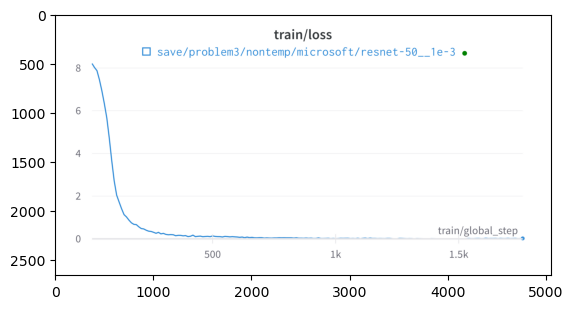

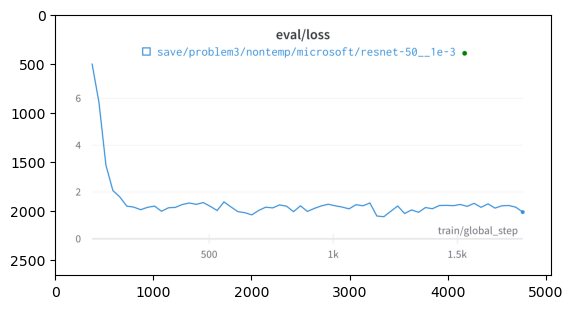

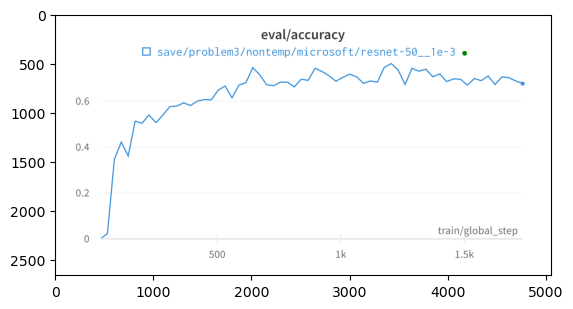

In [23]:
plt.figure()
img = mpimg.imread("./log/problem3/exp1/exp1_train_loss.png")
plt.imshow(img)

plt.figure()
img = mpimg.imread("./log/problem3/exp1/exp1_valid_loss.png")
plt.imshow(img)

plt.figure()
img = mpimg.imread("./log/problem3/exp1/exp1_valid_acc.png")
plt.imshow(img)

### Experiment 2: Weighted Non-Temporal Surgical Phase Recognition

### Experiment 3: Temporal Surgical Phase Recognition (Non-Weighted)

In [20]:
exp3_img_enc = AutoModelForImageClassification.from_pretrained(f"save/problem3/nontemp/{model_name_or_path}__1e-3")

#### Function declarations

In [21]:
def temporal_collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    
    all_pixel_values = [pixel_values]
    
    for i in range(NUM_PREV_FRAMES):
        prev_pixel_values = torch.stack([example[f"pixel_values_prev_frame_{i}"] for example in examples])
        all_pixel_values.append(prev_pixel_values)
    all_pixel_values = torch.stack(all_pixel_values)
    
    # (NUM_PREV_FRAMES + 1) x BATCH_SIZE x DIM
    return {"pixel_values": all_pixel_values, "labels": labels}

In [22]:
class TemporalNetwork(nn.Module):
    
    def __init__(self, img_enc, temporal_lstm):
        super().__init__()
        self.img_enc = img_enc
        self.temporal_lstm = temporal_lstm
        
    def forward(self, pixel_values, labels=None):
        img_features = []
        for frame_i in range(pixel_values.shape[0]):
            img_enc_results = self.img_enc(pixel_values[frame_i], output_hidden_states=True)
            img_features.append(img_enc_results.hidden_states[-1])
        img_features = torch.stack(img_features)
        img_features = torch.swapaxes(img_features, 0, 1) # Swap axes so batch axis is the first
        logits = self.temporal_lstm.forward(img_features, labels=labels)
        return logits

In [23]:
class TemporalLSTM(nn.Module):
    
    def __init__(self, input_size=2048*7*7, hidden_size=1024, num_layers=1, bidirectional=False, num_labels=NUM_CLASSES):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bidirectional = bidirectional
        self.num_labels = num_labels
        
        self.lstm = nn.LSTM(self.input_size, self.hidden_size, self.num_layers, batch_first=True)
        nn.init.xavier_normal_(self.lstm.all_weights[0][0])
        nn.init.xavier_normal_(self.lstm.all_weights[0][1])
        self.classifier = nn.Linear(self.hidden_size * (2 if self.bidirectional else 1), self.num_labels)

    def forward(self, x, labels=None):
        x = x.reshape(x.shape[0], x.shape[1], -1)
        self.lstm.flatten_parameters()
        y, _ = self.lstm(x)
        logits = self.classifier(y)
        loss = None
        if labels is not None:
            logits = logits[:, 0, :]
            loss_fct = F.cross_entropy
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
        return loss, logits
    
#         y = y.contiguous().view(-1, self.hidden_size)
#         y = y[self.sequence_length - 1::self.sequence_length]
#         return y

In [24]:
class TemporalTrainer(Trainer):
    pass

In [25]:
def temporal_training(
    model,
    output_dir=f"save/problem3/temp/{model_name_or_path}__1e-3",
    train_dataset=proc_datasets["train"],
    eval_dataset=proc_datasets["valid"],
    trainer_class=TemporalTrainer,
):
    args = TrainingArguments(
        output_dir,
        remove_unused_columns=False,
        evaluation_strategy = "epoch",
        save_strategy = "epoch",
        learning_rate=1e-3,
        per_device_train_batch_size=8,
        gradient_accumulation_steps=4,
        per_device_eval_batch_size=8,
        num_train_epochs=200,
        warmup_ratio=0.1,
        logging_steps=10,
        load_best_model_at_end=True,
        metric_for_best_model="eval_accuracy",
        gradient_checkpointing=False,
        save_total_limit=1,
        seed=RANDOM_SEED,
        data_seed=RANDOM_SEED,
        dataloader_num_workers=4,
        lr_scheduler_type="cosine",
        fp16=True,
        report_to="wandb",
        run_name=output_dir, 
    )
    
    trainer = trainer_class(
        model,
        args,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset,
        tokenizer=feature_extractor,
        compute_metrics=compute_metrics,
        data_collator=temporal_collate_fn,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=20)],
    )
    
    train_results = trainer.train()
    trainer.save_model()
    
    return trainer

In [26]:
exp3_temporal_lstm = TemporalLSTM()

In [27]:
exp3_temporal_network = TemporalNetwork(exp3_img_enc, exp3_temporal_lstm)

In [ ]:
temporal_trainer = temporal_training(
    exp3_temporal_network,
    output_dir=f"save/problem3/temp/{model_name_or_path}__1e-3",
    train_dataset=proc_datasets["train"],
    eval_dataset=proc_datasets["valid"],
    trainer_class=TemporalTrainer)

Using cuda_amp half precision backend
/home/holy/anaconda3/envs/health/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 3570
  Num Epochs = 200
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 4
  Total optimization steps = 22200
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"
wandb: Currently logged in as: holylovenia. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss
